<a href="https://colab.research.google.com/github/syedanida/deep-learning-multimodal-colabs/blob/main/6_Segment_Anything_Model_(SAM)_Demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q opencv-python matplotlib
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry
import torch
import requests
from PIL import Image
import io

In [5]:
# Download SAM checkpoint
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [6]:
# Setup SAM
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "./sam_vit_h_4b8939.pth"

In [7]:
# Load the model
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)
predictor = SamPredictor(sam)

In [8]:
# Load a sample image
def load_image_from_url(url):
    """Load image from URL."""
    response = requests.get(url)
    image = Image.open(io.BytesIO(response.content))
    return np.array(image)

In [9]:
# Download sample image
image_url = "https://images.pexels.com/photos/416160/pexels-photo-416160.jpeg?auto=compress&cs=tinysrgb&w=800"
image = load_image_from_url(image_url)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [10]:
# Set the image for prediction
predictor.set_image(image_rgb)

In [11]:
# Function to show mask
def show_mask(mask, ax, random_color=False):
    """Display segmentation mask."""
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [12]:
def show_points(coords, labels, ax, marker_size=375):
    """Show points on image."""
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green',
               marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red',
               marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

In [13]:
def show_box(box, ax):
    """Show bounding box."""
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green',
                              facecolor=(0,0,0,0), lw=2))

# Interactive segmentation with points
# Define input points and labels (1 for foreground, 0 for background)
input_point = np.array([[500, 375]])  # Example point
input_label = np.array([1])  # 1 means foreground point

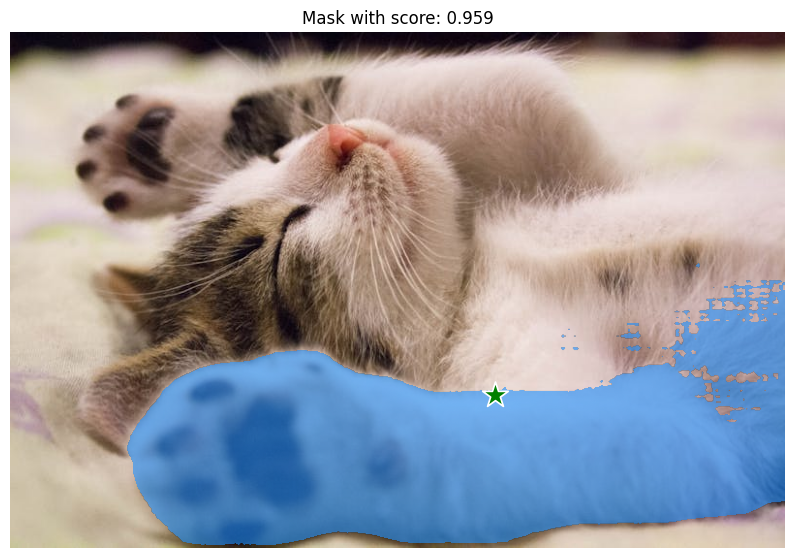

In [14]:
# Generate mask
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

# Display results
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_points(input_point, input_label, plt.gca())
plt.title(f"Mask with score: {scores[0]:.3f}")
plt.axis('off')
plt.show()

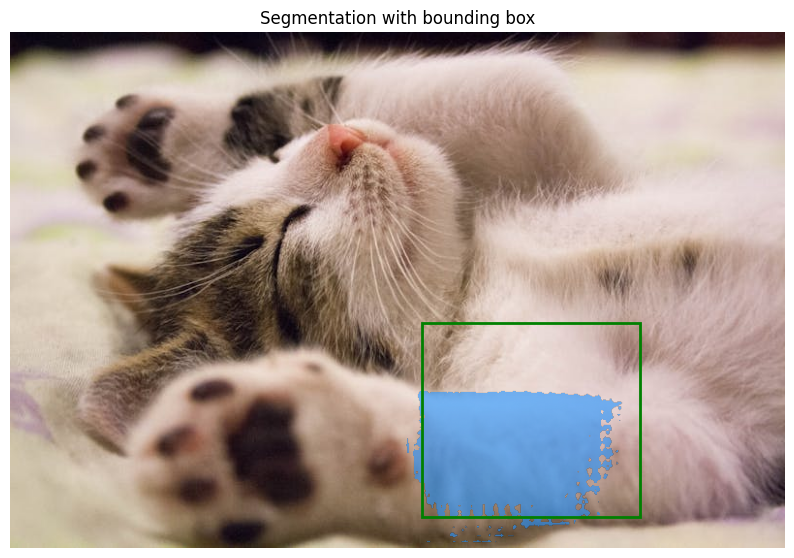

In [15]:
# Segmentation with bounding box
input_box = np.array([425, 300, 650, 500])  # x0, y0, x1, y1

masks, scores, logits = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.title("Segmentation with bounding box")
plt.axis('off')
plt.show()

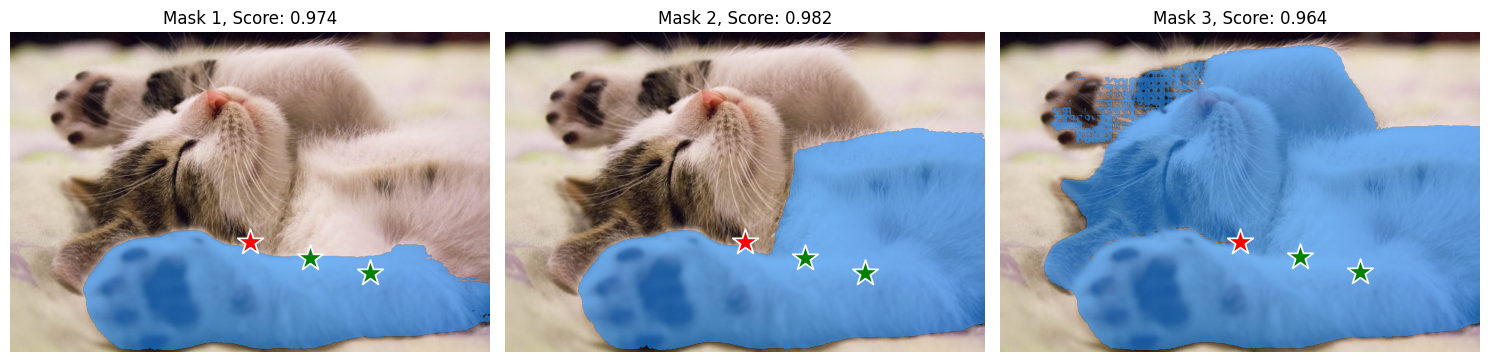

In [16]:
# Multiple point segmentation
input_points = np.array([[500, 375], [600, 400], [400, 350]])
input_labels = np.array([1, 1, 0])  # Mix of foreground and background points

masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=True,
)

# Show all masks
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (mask, score) in enumerate(zip(masks, scores)):
    axes[i].imshow(image)
    show_mask(mask, axes[i])
    show_points(input_points, input_labels, axes[i])
    axes[i].set_title(f"Mask {i+1}, Score: {score:.3f}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [17]:
# Batch processing function
def segment_objects(image, points_list):
    """Segment multiple objects in an image."""
    predictor.set_image(image)
    all_masks = []

    for points, labels in points_list:
        masks, _, _ = predictor.predict(
            point_coords=points,
            point_labels=labels,
            multimask_output=False,
        )
        all_masks.append(masks[0])

    return all_masks

In [18]:
# Fine-tuning example (conceptual - requires more setup)
def prepare_sam_for_finetuning(sam_model, custom_dataset):
    """Prepare SAM for fine-tuning on custom dataset."""
    # Freeze early layers
    for param in sam_model.image_encoder.parameters():
        param.requires_grad = False

    # Only fine-tune the mask decoder
    for param in sam_model.mask_decoder.parameters():
        param.requires_grad = True

    # Setup optimizer
    optimizer = torch.optim.Adam(
        sam_model.mask_decoder.parameters(),
        lr=1e-4
    )

    return optimizer

print("SAM demonstration complete!")

SAM demonstration complete!
